In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import json
import multiprocessing as mp


from tqdm import tqdm

from sklearn.cluster import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_mutual_info_score, calinski_harabasz_score 
from sklearn.preprocessing import normalize

from run.experiment import preprocess


## Utility

In [4]:
# serializes array of sklearn objecs
def serialize(array):
    serialized = []
    for object in array:
        serialized.append(str(object))
    return serialized

def load_result(number):

    results_path = "{}/run/results".format(os.getcwd())
   
    current_result_folder_path = "{}/{}/".format(results_path, number)

    with open("{}/{}".format(current_result_folder_path, 'df.pickle'), 'rb') as file:
        df = pickle.load(file)    
    
    with open("{}/{}".format(current_result_folder_path, 'scores.pickle'), 'rb') as file:
        scores = pickle.load(file)

    with open("{}/{}".format(current_result_folder_path, 'models.pickle'), 'rb') as file:
        models = pickle.load(file)

    # store configuration in folder
    with open("{}/{}".format(current_result_folder_path, 'configuration.json'), 'r') as file:
        config = json.load(file)
    
    return scores, config, models, df



# Clustering Analysis

Select subsets of variables ~4 or so and then cluster those. Also use different clustering algorithms and then implement some measure of how well the cluster separates the variables (in 1D).

Run the experiment in the run folder and then analyze results below.

## Analysis

In [15]:
# visualize for each variable pair in the subset how well they are separated
def visualize(imputation_method, algo, variable_subset_df, model):
    print("{} - {}".format(algo, imputation_method))
    variable_subset_df = preprocess(imputation_method, variable_subset_df)
    
    predicted_clusters = model.predict(variable_subset_df)

    variable_subset_df['predicted_cluster'] = pd.Series(predicted_clusters)

    variables = variable_subset_df.columns
    num_variables = len(variables) - 1

    figure, axis = plt.subplots(num_variables, num_variables, figsize=(20, 20))

    for i in range(num_variables):
        for j in range(i, num_variables):
            clusters = np.unique(predicted_clusters)
            for cluster in clusters:
                
                x = variable_subset_df[variable_subset_df['predicted_cluster'] == cluster][variables[i]]
                y = variable_subset_df[variable_subset_df['predicted_cluster'] == cluster][variables[j]]
                
                axis[j,i].scatter(x,y)     


            axis[j,i].set_xlabel(variables[i])    
            axis[j,i].set_ylabel(variables[j])    
    plt.show()

           




KMeans(n_clusters=3, random_state=42) - mean


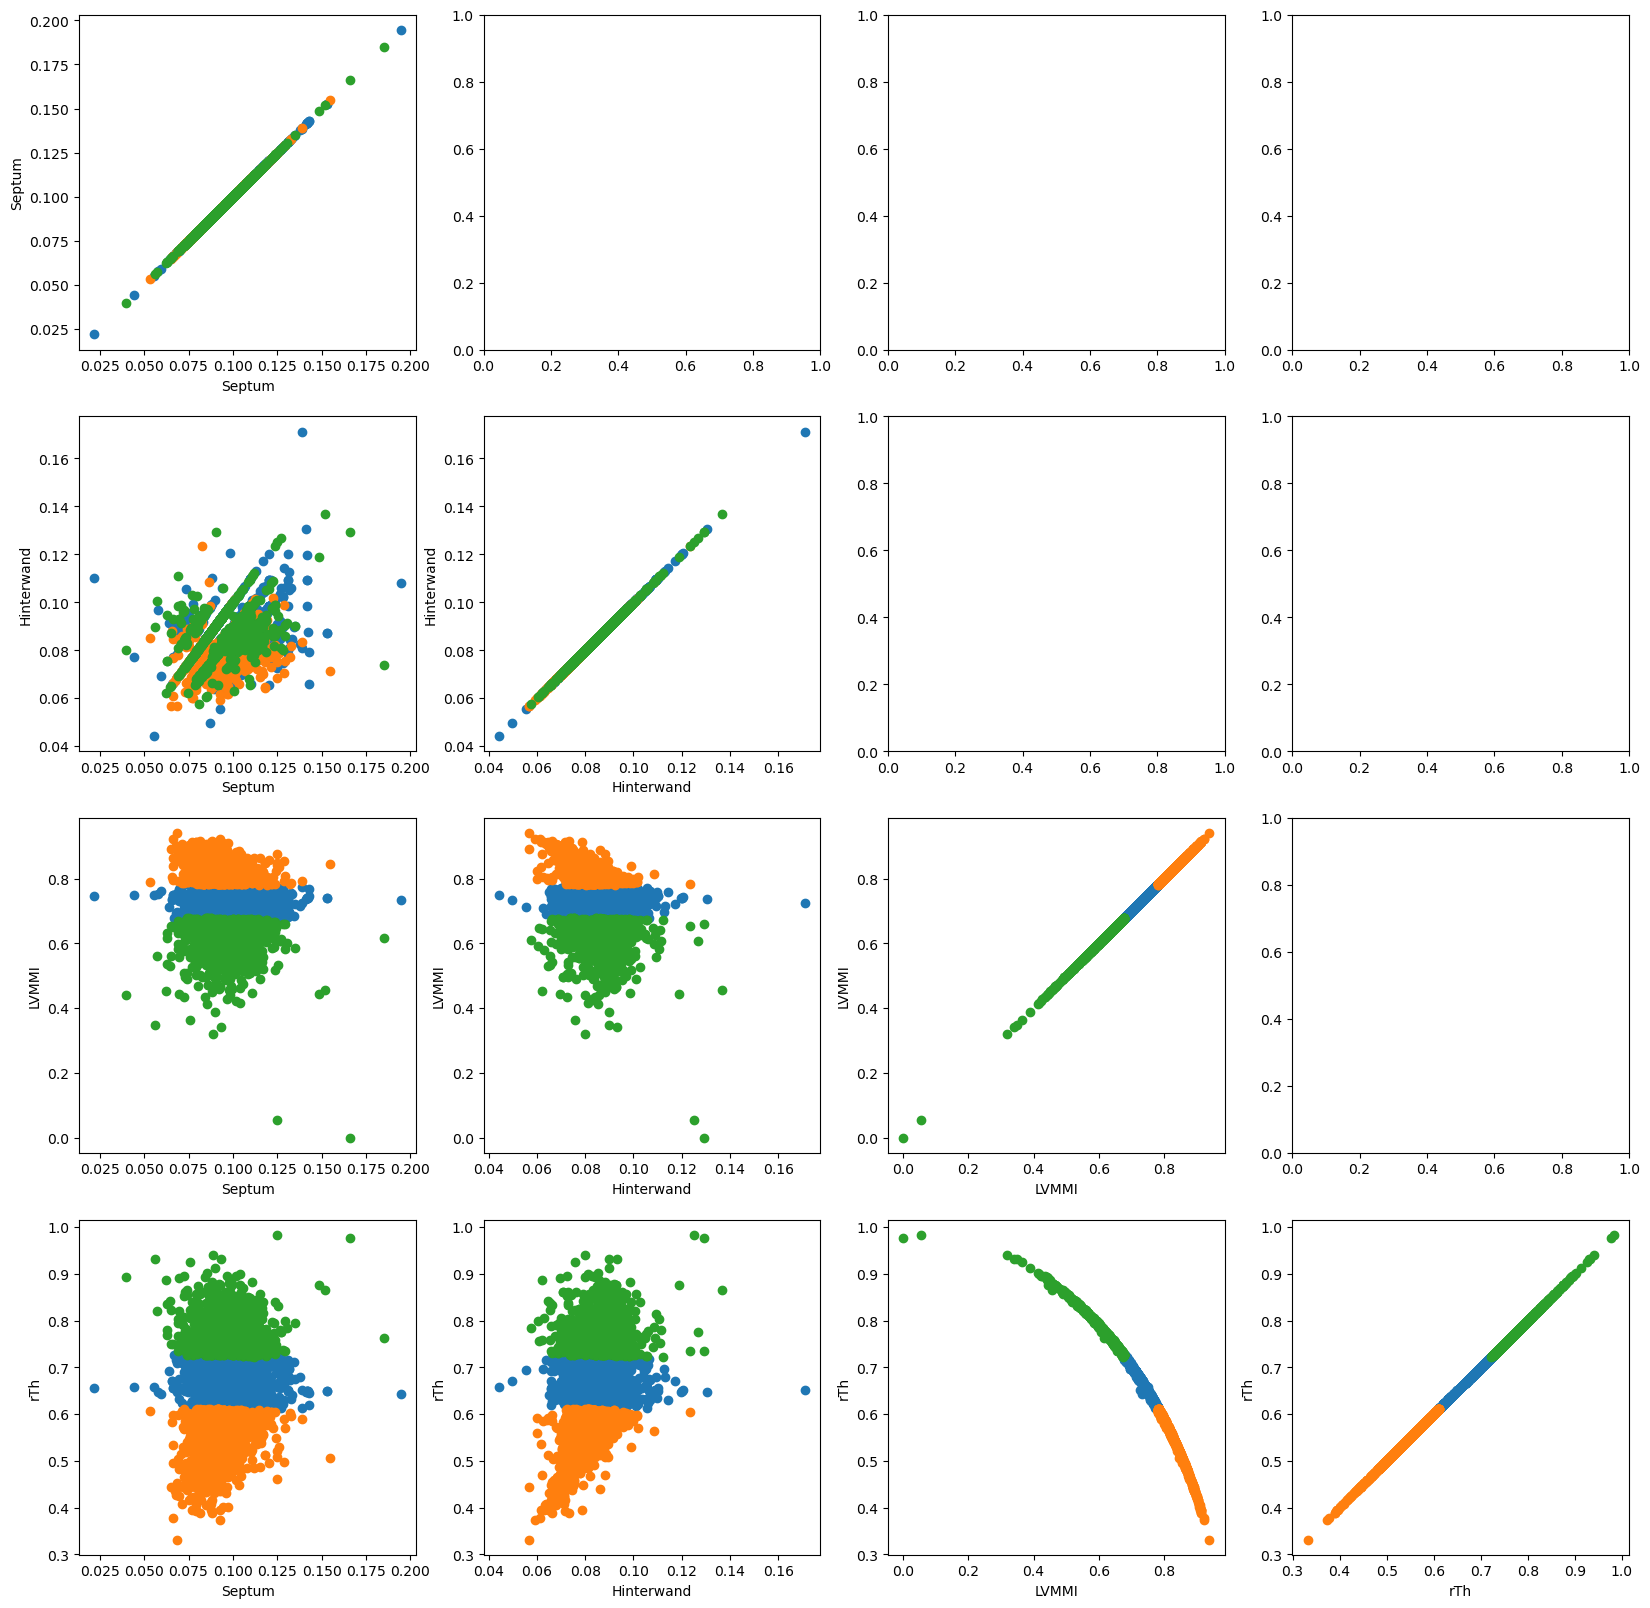

KMeans(n_clusters=3, random_state=42) - mean


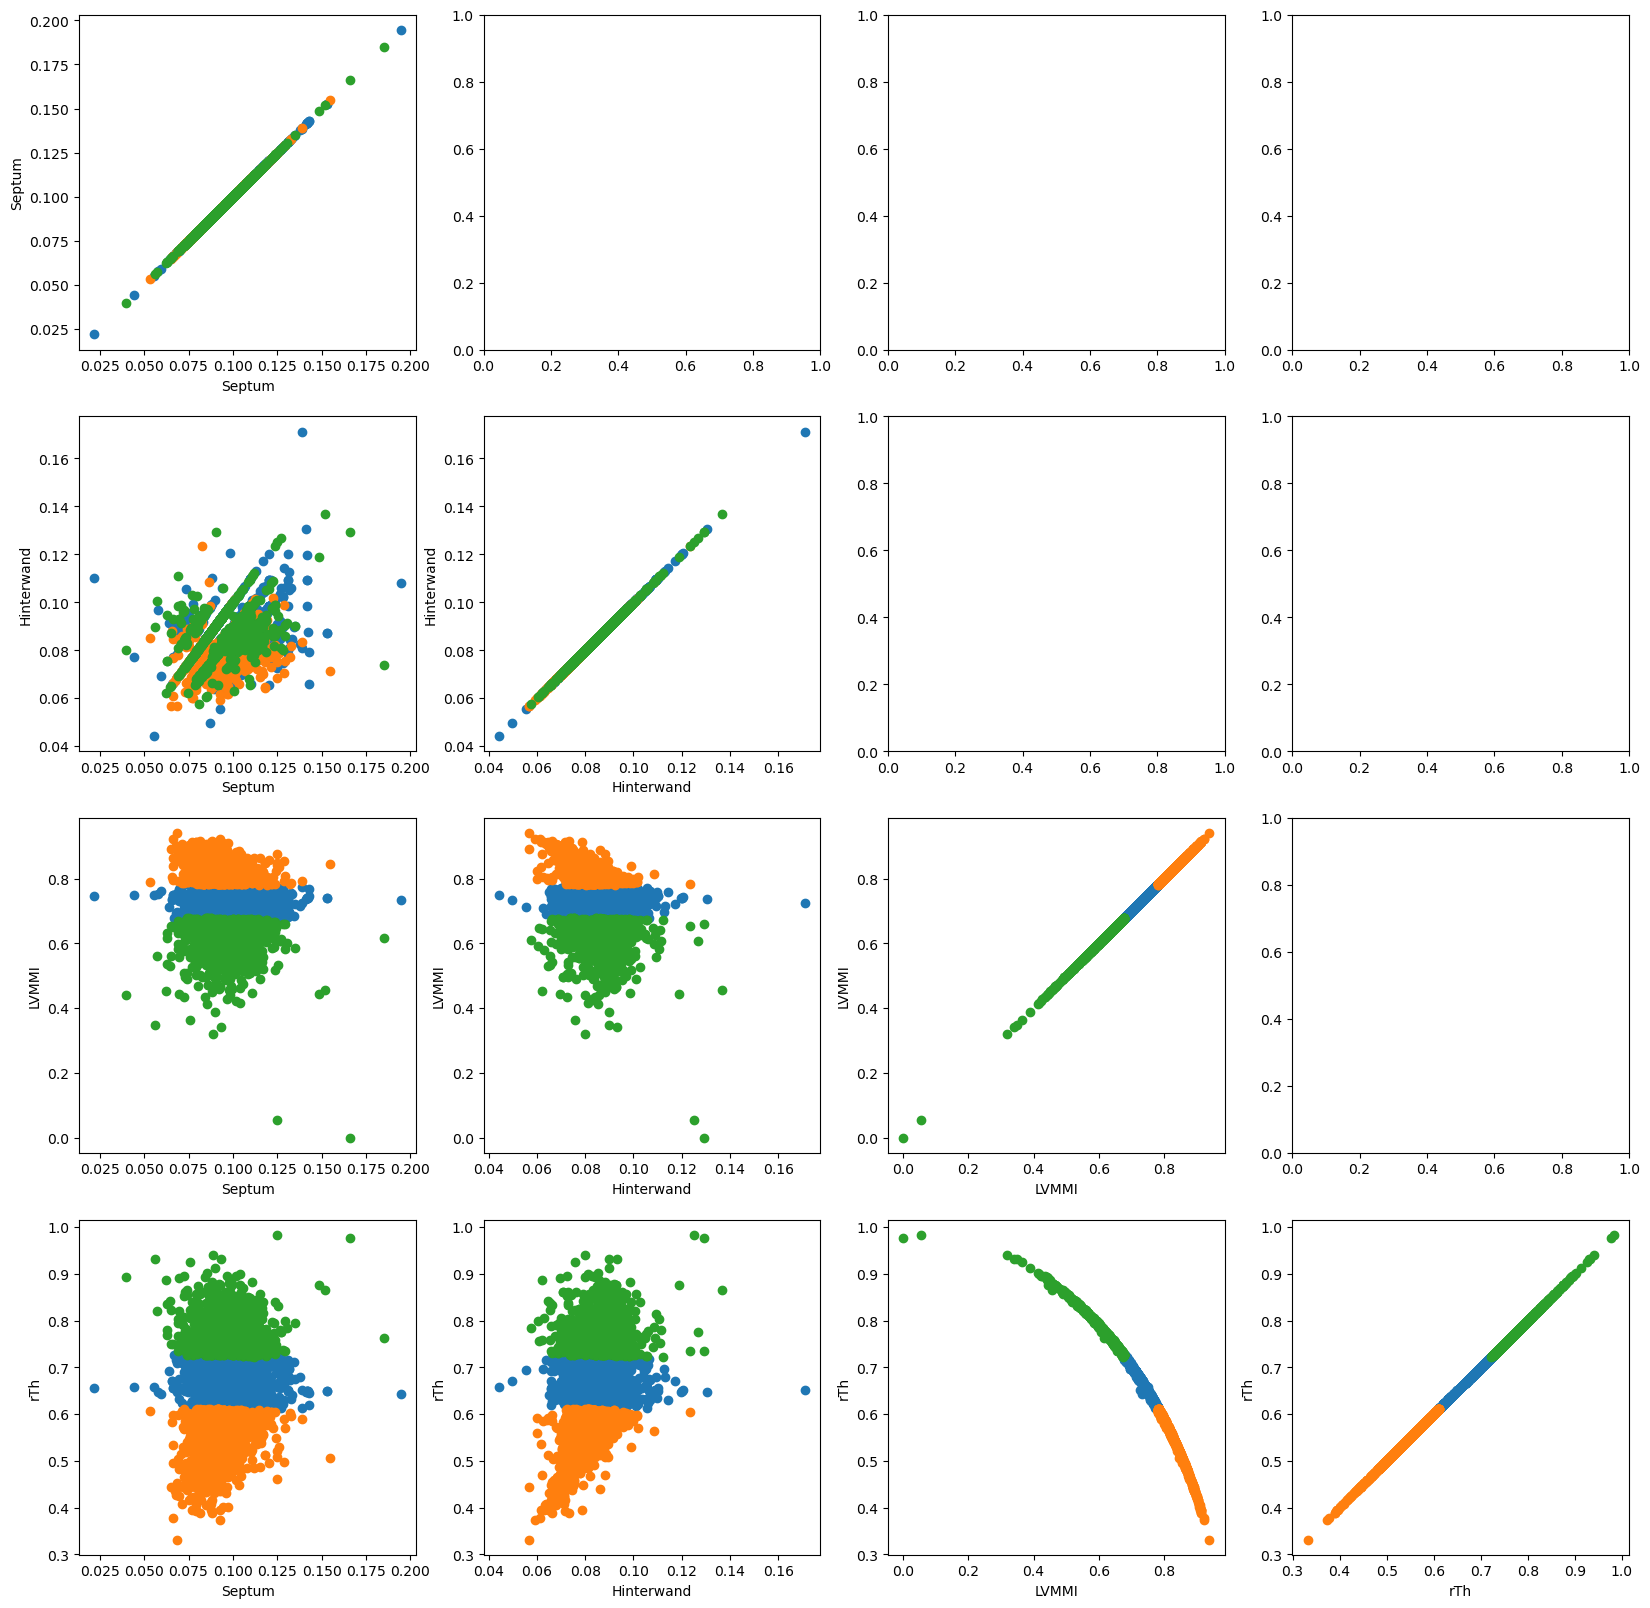

KMeans(n_clusters=3, random_state=42) - mean


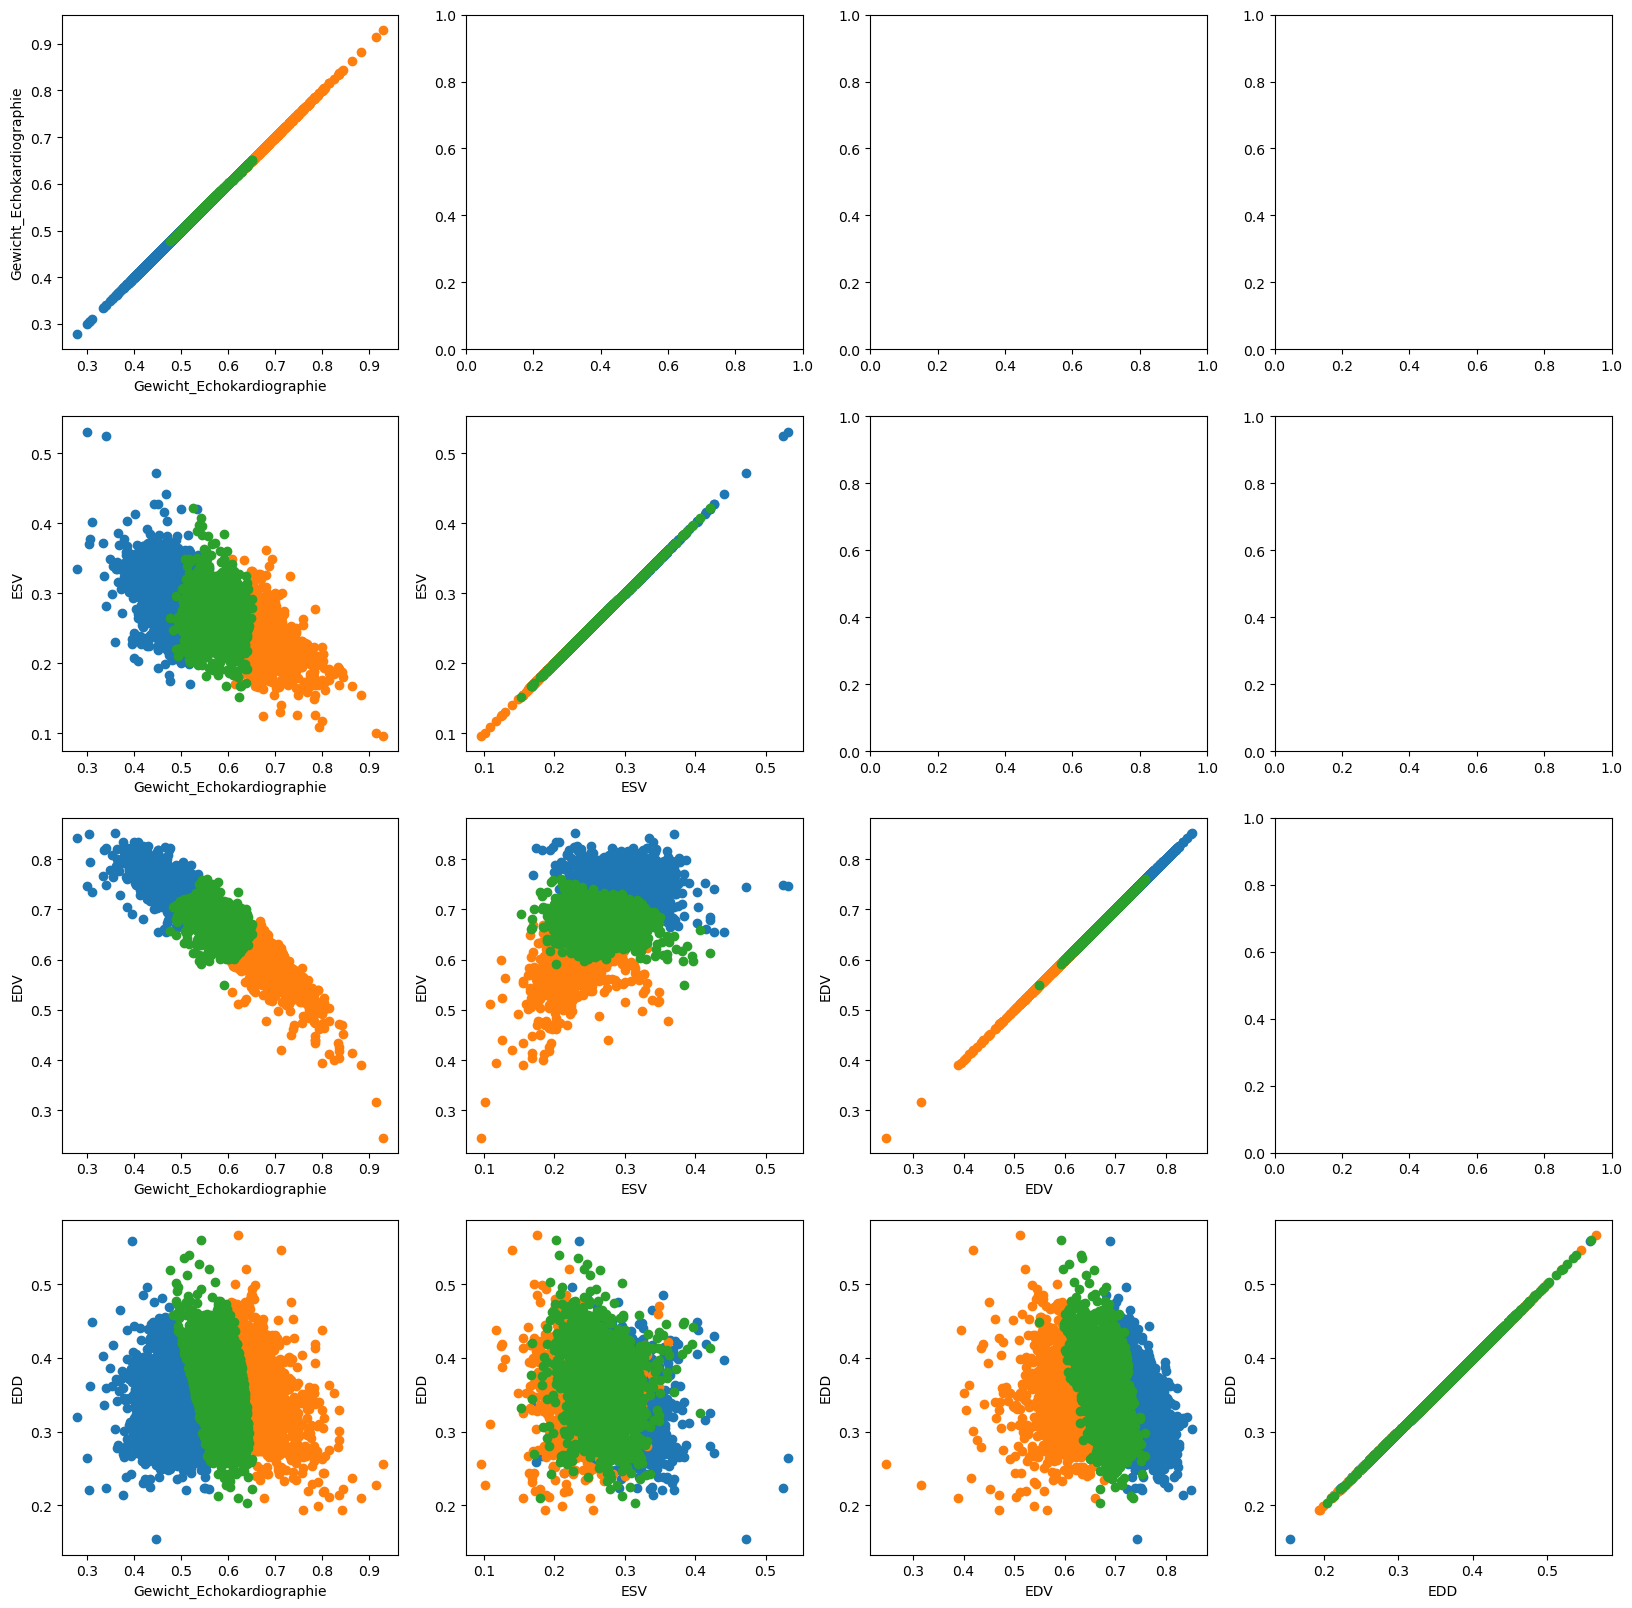

In [18]:
scores, config, models, df = load_result(7)

algorithms = serialize(config['algorithms'])
imputation_methods = serialize(config['imputation_methods'])
num_imputation_methods = len(imputation_methods)
measures = config['measures']
variable_subsets = config['subset_sizevariable_subsets']
num_subsets = len(variable_subsets)

# average scores
average_scores = np.nanmean(scores, axis=(0,1,2))
#print("Average scores:",  average_scores)

# best score per algorithm
max_scores = np.nanargmax(scores, axis=1)

# for each imputation method, algorithm and measure show the variable subset with the highest score
for imputation_idx in range(scores.shape[2]):
    imputation_method = imputation_methods[imputation_idx]
    #print("{}".format(imputation_method))

    for algo_idx in range(scores.shape[0]):
        algo = algorithms[algo_idx]
        #print("    {}".format(algo))
        
        for measure_idx in range(scores.shape[3]):
            measure = measures[measure_idx]
            max_score_idx = max_scores[algo_idx, imputation_idx, measure_idx]
            max_score = scores[algo_idx, max_score_idx, imputation_idx, measure_idx]
            #print("        {}: {} ({})".format(measure, max_score, variable_subsets[max_score_idx]))

            model = models[algo_idx][max_score_idx][imputation_idx]
            visualize(imputation_method, algo, df[variable_subsets[max_score_idx]], model)

        
